In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())  # read local .env file

import time
import pickle

import handoff_eval

# Load data

In [3]:
data_path = "../data/ai_ml_take_home"
ground_truth_path = os.path.join(data_path, "ground_truth")
model_outputs_path = os.path.join(data_path, "model_outputs")

In [4]:
ground_truth_data = handoff_eval.data_preparation.load_json_files(ground_truth_path)
model_output_data = handoff_eval.data_preparation.load_json_files(model_outputs_path)

# Evaluation run

In [5]:
run_number = 3
# load_run = True
load_run = False
# save_run = False
save_run = True

eval_file_path = "../data/evaluations/matched_pairs_dict_" + str(run_number) + ".pkl"

In [6]:
if load_run:
    with open(eval_file_path, "rb") as f:
        matched_pairs_dict = pickle.load(f)

else:
    start_time = time.time()

    async def run_async_processing():
        return await handoff_eval.data_preparation.process_all_models_async(model_output_data, ground_truth_data)

    matched_pairs_dict = await run_async_processing()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"process_all_models_async - total execution time: {total_time:.2f} seconds")

    if save_run:
        # Save the dictionary to a pickle file
        with open(eval_file_path, "wb") as f:
            pickle.dump(matched_pairs_dict, f)
# process_all_models_async - total execution time: 41.90 seconds

2025-03-18 21:12:06,467 - INFO - handoff_eval - Step 1: Generating matched_pairs for all models.
2025-03-18 21:12:11,624 - INFO - handoff_eval - Step 2: Processing all matched_pairs asynchronously.
2025-03-18 21:12:48,364 - INFO - handoff_eval - Step 3: Updating matched_pairs_dict with processed results.
2025-03-18 21:12:48,366 - INFO - handoff_eval - Processing complete.


process_all_models_async - total execution time: 41.90 seconds


# Visualize main metrics by model

2025-03-18 21:12:48,477 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:12:48,490 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


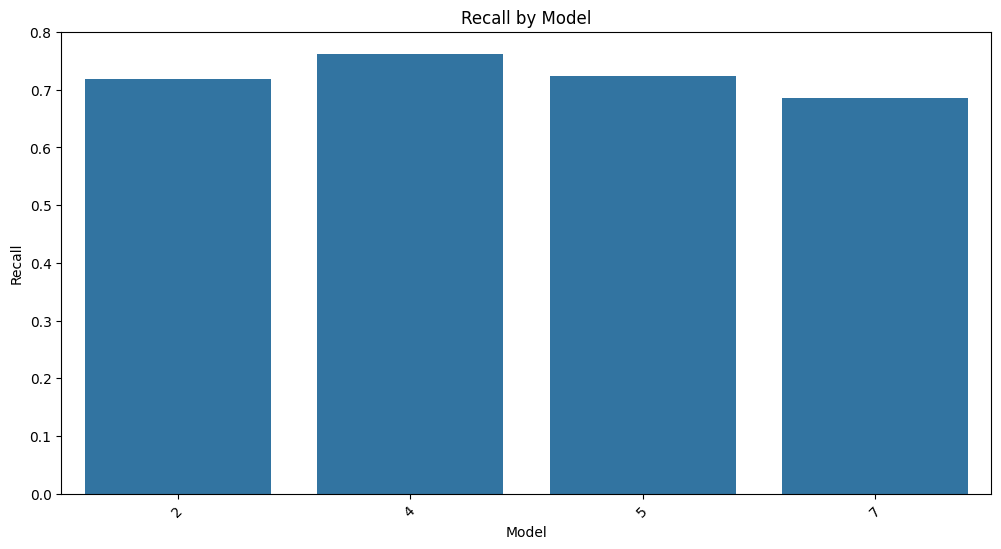

2025-03-18 21:12:48,662 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:12:48,668 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


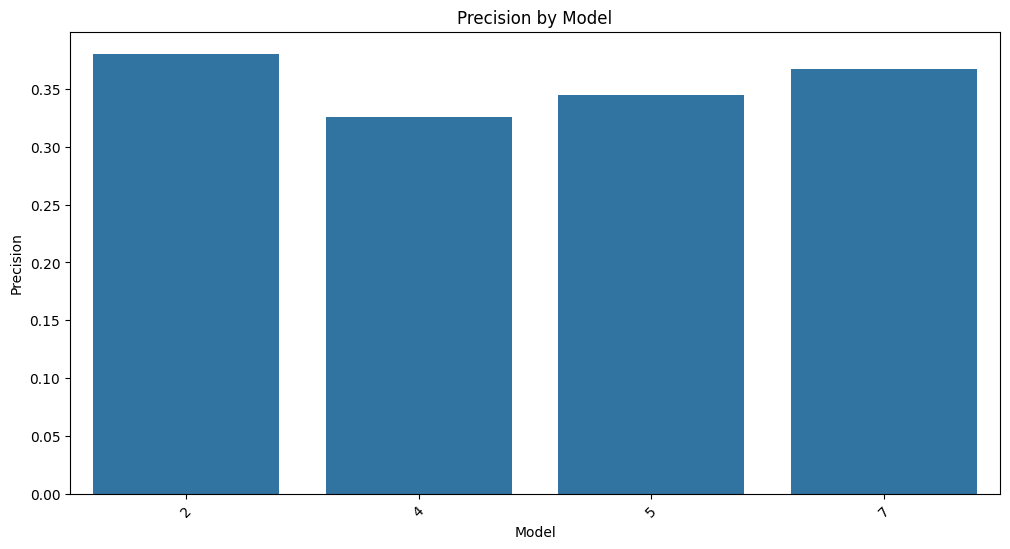

2025-03-18 21:12:48,804 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 21:12:48,809 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


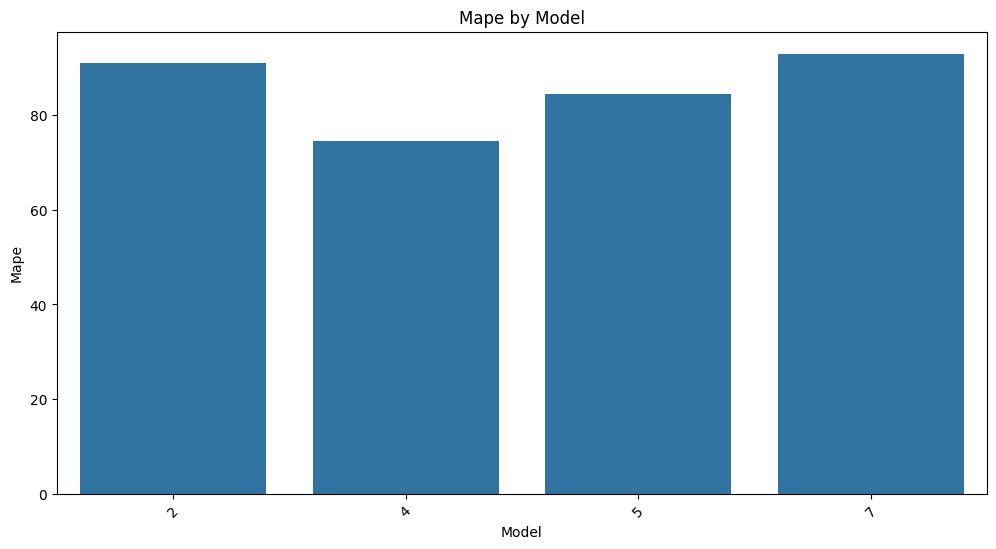

In [7]:
# --- Plotting ---
x = "model"

# Recall
error_type = "recall"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Precision
error_type = "precision"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Mape of rowTotalCostUsd
metric = "rowTotalCostUsd"
error_type = "mape"
df_metrics = handoff_eval.evaluation.compute_model_metrics_df(matched_pairs_dict, metric=metric, error_type=error_type)
handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

# Investigate main metrics by example for each model

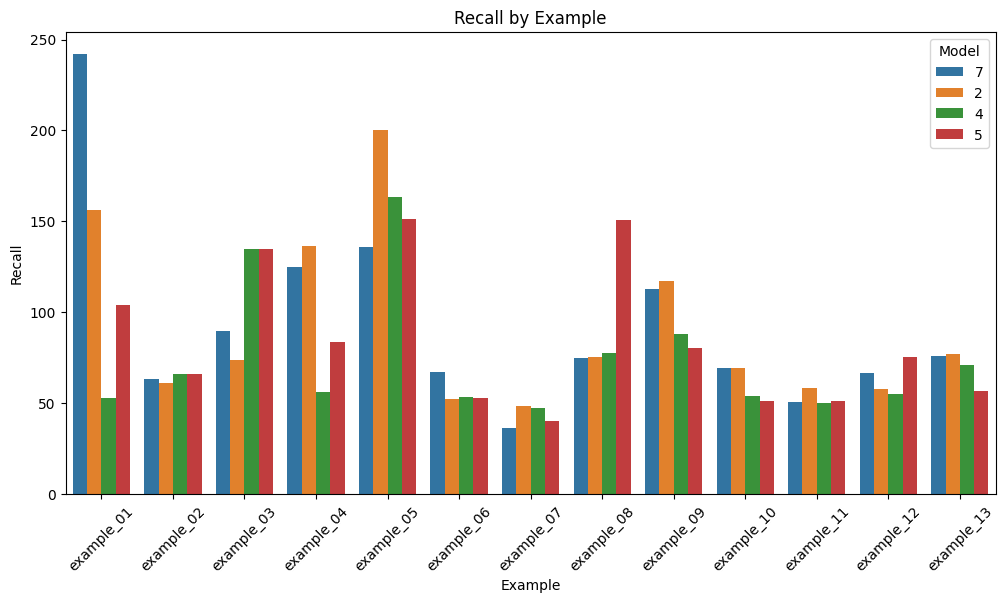

In [8]:
x = "example"
# Recall
error_type = "recall"

handoff_eval.evaluation.plot_model_metrics(df_metrics, x=x, metric_name=error_type.capitalize())

In [9]:
# Find best model based on best f1 and best MAPE
agg_recall, _ = handoff_eval.evaluation.aggregate_by_model(df_metrics)
agg_recall

,model,value
0,2,90.945837
1,4,74.494476
2,5,84.459799
3,7,92.967552


# Simple example to illustrate the methodology

In [10]:
from handoff_eval.constants import LINE_ITEM_INFO
sel_cols = [col for pair in [(f"gt_{key}", f"pred_{key}") for key in LINE_ITEM_INFO] for col in pair]

In [11]:
matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols].head()

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,gt_qty,pred_qty,gt_rateUsd,pred_rateUsd,gt_rowTotalCostUsd,pred_rowTotalCostUsd
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1.0,1.0,400.0,250.0,400.0,250.0
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,66.0,150.0,16.0,8.0,1056.0,1200.0
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,73.0,74.0,16.0,8.0,1168.0,592.0
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,73.0,75.0,2.4,0.3,175.2,22.5
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,288.0,188.0,2.4,0.3,691.2,56.4


In [14]:
import pandas as pd
pd.set_option("display.max_colwidth", None)  # Show full text in all columns

matched_pairs_dict["2"]["example_01"]["matched_pairs_data"][sel_cols[:8] + ["similar_task", "justification"]].head(10)

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,similar_task,justification
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1,"yes. ""install toilet"" and ""toilet"" likely refer to the same construction task, which involves the installation of a toilet fixture in a residential setting."
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,1,"yes. both labels refer to the task of installing tile on a wall, specifically in a shower area."
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,1,"yes. both labels refer to the task of installing tile on a floor surface, with the second label specifying that the tile installation is specifically for a bathroom floor."
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,1,"yes. both labels refer to tasks related to preparing and painting the ceiling, with the first label specifying the number of coats to be applied."
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,1,"yes\n\njustification: both labels are related to the process of preparing and painting walls, with the first label specifying the number of coats and the second label focusing on the preparation of wall surfaces before painting."
5,Demo Shower Surround,Protect Work Area and Surroundings,Demolition,Demolition,SF,SF,other,labor,0,"no. \n\n'demo shower surround' typically refers to the demolition or removal of an existing shower surround, while 'protect work area and surroundings' involves safeguarding the construction site and its surroundings from potential damage during the project."
6,Demo Vanity,Demo Vanity,Demolition,Demolition,EA,HRS,other,labor,1,"yes. both labels ""demo vanity"" likely refer to the demolition of a vanity in a construction project, indicating the removal of the existing vanity fixture."
7,Demo Tub,Demo Tub,Demolition,Demolition,EA,HRS,other,labor,1,"yes. both labels ""demo tub"" likely refer to the same construction task of demolishing or removing a bathtub."
8,Demo Plumbing Fixtures,Disposal Costs,Demolition,Demolition,EA,EA,other,labor plus material,1,"yes. \n\njustification: ""demo plumbing fixtures"" typically involves removing and disposing of old plumbing fixtures, which aligns with ""disposal costs"" related to the removal and disposal of construction waste."
9,Install Shower Pan,Pipe Fittings and Adhesives,Plumbing,Plumbing,EA,EA,other,material,0,"no. 'install shower pan' typically involves setting up the base of a shower, while 'pipe fittings and adhesives' refers to connecting plumbing components, which are separate tasks in a construction project."


In [13]:
pd.reset_option("display.max_colwidth")